<a href="https://colab.research.google.com/github/Manuelstv/astro-ml/blob/main/CubeNet7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install libraries
#%matplotlib inline
!apt-get -y install -qq graphviz
!pip install -U -q astropy
!pip install -U -q pydot
!pip install -U -q pydot_ng
!pip install -U -q graphviz

     |████████████████████████████████| 6.3MB 3.1MB/s 


In [ ]:
# import libraries
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pylab as py
import cv2
import h5py

import scipy
import scipy.misc
import warnings
import os
import keras
import pydot
import pydot_ng
import time
import tensorflow as tf
import timeit
import matplotlib.pyplot as plt


from google.colab import drive
from google.colab import files
from astropy.io import fits
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras.utils import plot_model
from IPython.display import Image, display
from keras import backend as K
from keras.preprocessing import image
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from keras.utils import to_categorical
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import MinMaxScaler

from keras.applications.resnet50 import ResNet50

warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
from google.colab import drive

# **Mount drive for save outputs**
**Let drive mount on your google drive and copy the code, go to colab and paste the code there**

In [ ]:
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/NewData"

/content/drive/My Drive/NewData


# Load data labels y_data

In [ ]:
#!ls
PATH = os.getcwd()
y_path = PATH+'/'
y_batch = os.listdir(y_path)
# Importing labels
labels = pd.read_csv('classifications2.csv',delimiter=',', header=-1)

y_data = np.array(labels, np.uint8)

#y_data = y_data[:,1]
#print(y_data[0,:])
print (y_data.shape)

(20000, 1)


# **Load x_data**


https://fits2hdf.readthedocs.io/en/latest/getting_started.html



https://python4astronomers.github.io/astropy/fits.html


In [ ]:
x_temp_data=fits.getdata("cubes.fits")
x_data = np.zeros((20000,101,101,1))

x_data[:,:,:,0] = x_temp_data[:,:,:,0]
#x_data[:,:,:,1] = x_temp_data[:,:,:,1]


print(x_data.shape)

  #image_orig= np.float32(image_dataR)
  #image_rotsub_name='imageEUC_VIS-'+str(nmbimg)+'_rotsub.fits'
  #image_rotsub = fits.getdata(image_rotsub_name)#, ext=0) %%
 
  #x_data[i,:,:,1]=image_rotsub

x_data = np.moveaxis(x_data, -1, 0) 
x_data = np.moveaxis(x_data, -3, 0)
print(x_data.shape)

(20000, 101, 101, 1)
(20000, 1, 101, 101)


# ** Preprocessing  data**


Training, test and validation data

In [ ]:
pVal = x_data.shape[0] / 100 * 10 # 10% data to validation 
x_val = x_data[1:int(pVal)+1,:,:,:]

ptest = pVal * 3 # 30% data to test
x_test = x_data[int(pVal)+2:(int(pVal)+2)+int(ptest)+1,:,:,:]

x_train = x_data[int(ptest+pVal):x_data.shape[0],:,:,:]
#x_train = x_data
#print(x_val)
print('Shape x ...')
print(x_val.shape)
print(x_test.shape)
print(x_train.shape)

y_val = y_data[1:int(pVal)+1,0]

y_test = y_data[int(pVal)+2:(int(pVal)+2)+int(ptest)+1,0]

y_train = y_data[int(ptest+pVal):x_data.shape[0],0]
 
print('Shape y ...')
print(y_val.shape)
print(y_test.shape)
print(y_train.shape)

print (x_train[1,0,:,:])

Shape x ...
(2000, 1, 101, 101)
(6001, 1, 101, 101)
(12000, 1, 101, 101)
Shape y ...
(2000,)
(6001,)
(12000,)
[[ 57.22544188  57.14465395  65.71274092 ...  21.12946512  99.13214967
  100.        ]
 [ 58.99291945  12.66032758  54.2403093  ...  55.04718693  71.91114754
   37.28007338]
 [ 71.86424146  28.63542338  48.07849027 ...  24.75434798  53.70436417
    8.58578354]
 ...
 [ 83.92854698  51.13376638  16.83821866 ...  41.28710817  69.05373524
   65.43526319]
 [100.          38.47920425  43.81225909 ...  35.62964917  42.31813592
   31.07855535]
 [ 53.43646676  18.99689972  68.02820221 ...  25.19401662  67.29649846
   33.87636477]]


# Create Model Sequential

In [ ]:
model = Sequential()


model.add(Convolution2D(64, (3, 3), input_shape=(x_data.shape[1],101,101), data_format='channels_first'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

model.add(Convolution2D(128, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

model.add(Convolution2D(256, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

model.add(Convolution2D(512, (3, 3), data_format='channels_first')) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),data_format='channels_first'))

#model.add(Dropout(0.5)) # 0.2
model.add(Flatten())

model.add(Dense(512)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(64)) 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Dense(2, activation= 'softmax' )) 

lr = 0.1
sgd = SGD(lr=lr, decay=1e-5, momentum=0.9, nesterov=True)


**Compile Model:**

In [ ]:
#model.load_weights('Train_fold_3weights_50.h5', by_name=True) ## if load weighs from .h5

model.compile(loss= 'binary_crossentropy' , optimizer=sgd , metrics=[ 'accuracy' ])
model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 99, 99)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 99, 99)        396       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 99, 99)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 49, 49)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 47, 47)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 47, 47)       188       
________________________

**In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better. Data Augmentation:**

In [ ]:
gen = ImageDataGenerator(rotation_range=90, zoom_range=[0.9,1], horizontal_flip=True, vertical_flip=True, fill_mode='wrap')

**A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. Building  Callbacks:**

In [ ]:
def get_callbacks(name_weights, patience_lr, name_csv):
    mcp_save = ModelCheckpoint(name_weights)
    csv_logger = CSVLogger(name_csv)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='max')
    return [mcp_save, csv_logger, reduce_lr_loss]

**Converts a class vector (integers) to binary class matrix:**

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Train

Show graphics loss x epoch and acc x epoch



Epoch 1/35
375/375 [==============================] - 77s 205ms/step - loss: 0.5738 - acc: 0.7123 - val_loss: 0.6791 - val_acc: 0.7010
Epoch 2/35
375/375 [==============================] - 63s 167ms/step - loss: 0.5410 - acc: 0.7349 - val_loss: 0.8663 - val_acc: 0.7010
Epoch 3/35
375/375 [==============================] - 63s 167ms/step - loss: 0.5321 - acc: 0.7423 - val_loss: 1.2105 - val_acc: 0.7010
Epoch 4/35
375/375 [==============================] - 63s 168ms/step - loss: 0.5174 - acc: 0.7511 - val_loss: 1.0901 - val_acc: 0.7010
Epoch 5/35
375/375 [==============================] - 64s 170ms/step - loss: 0.5089 - acc: 0.7597 - val_loss: 2.8259 - val_acc: 0.7010
Epoch 6/35
375/375 [==============================] - 65s 172ms/step - loss: 0.5026 - acc: 0.7592 - val_loss: 1.1686 - val_acc: 0.7010
Epoch 7/35
375/375 [==============================] - 64s 172ms/step - loss: 0.4984 - acc: 0.7613 - val_loss: 0.6754 - val_acc: 0.7010
Epoch 8/35
375/375 [==============================] -

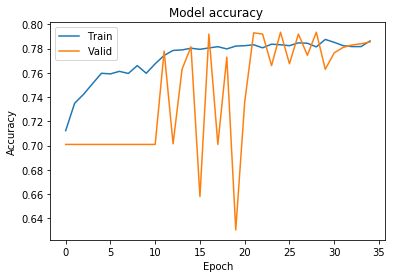

<Figure size 432x288 with 0 Axes>

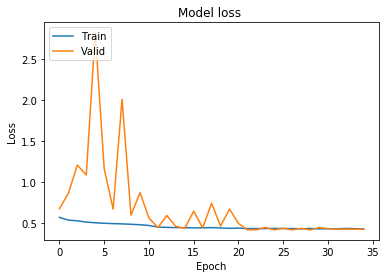

Elapsed 2343.883 seconds.


<Figure size 432x288 with 0 Axes>

In [ ]:

batch_size=32
start = time.perf_counter()

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
# The first is the allow_growth option, which attempts to allocate only as much
# GPU memory based on runtime allocations: it starts out allocating very little 
# memory, and as Sessions get run and more GPU memory is needed, we extend the GPU memory region needed by 
# the TensorFlow process. Note that we do not release memory, since that can lead 
# to even worse memory fragmentation. To turn this option on, set the option in the ConfigProto by:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)


name_weights = "Train_model_weights_{epoch:02d}.h5"
csv_name = "trainning_k.csv"
callbacks = get_callbacks(name_weights = name_weights, patience_lr=10, name_csv = csv_name)
generator = gen.flow(x_train, y_train, batch_size = batch_size)
# change epochs


history = model.fit_generator(
                  generator,
                  steps_per_epoch=len(x_train)/batch_size,
                  epochs=35,
                  verbose=1,
                  validation_data = (x_val, y_val),
                  validation_steps = len(x_val),
                  callbacks = callbacks)
      
      
###### Plot training & validation accuracy values
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy ' )
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.savefig("AccxEpoch.png")

###### Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
plt.savefig("LossxEpoch.png")


sess.close()

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)            

AUC: 0.862


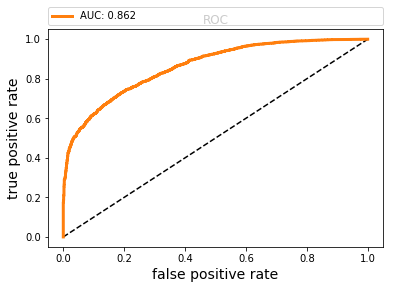

<Figure size 432x288 with 0 Axes>

In [ ]:
#print(model.evaluate(x_test, y_test)) 
      
probs = model.predict_proba(x_test)
######## keep probabilities for the positive outcome only
probsp = probs[:, 1]
######## calculate AUC
auc = roc_auc_score(y_test[:,1], probsp)
print('AUC: %.3f' % auc)

      
######## calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test[:,1], probsp)


plt.figure()
plt.plot([0, 1], [0, 1], 'k--') # k = color black
plt.plot(fpr, tpr, label="AUC: %.3f" % auc, color='C1', linewidth=3) # for color 'C'+str(j), for j[0 9]
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
plt.title('ROC')
plt.xlabel('false positive rate', fontsize=14)
plt.ylabel('true positive rate', fontsize=14)
    
plt.show()
plt.savefig("ROCLensDetectNet.png")

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Large CNN Error: 20.63%


In [ ]:
import matplotlib.pyplot as plt
# Predict single images
n_images = 8
# Get images from test set
test_images = x_test[:n_images]
# Predicts
# Use the model to predict the images class
preds = list(model.predict_proba(test_images))
# print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
# Display
vout = (0,255)
for i in range(n_images):
    output=np.where(preds[i]==preds[i].max())
    print("Model prediction:", output[0][0])
    #print(y_test[:,1])
    print("Real:", np.uint8(y_test[i,1]))

Model prediction: 1
Real: 1
Model prediction: 0
Real: 1
Model prediction: 1
Real: 1
Model prediction: 0
Real: 0
Model prediction: 1
Real: 1
Model prediction: 0
Real: 0
Model prediction: 1
Real: 1
Model prediction: 1
Real: 0
